In [31]:
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD , Adam, RMSprop
from keras.layers import PReLU
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
visited_mark = 0.8  # Cells visited by the rat will be painted by gray 0.8
rat_mark = 0.5      # The current rat cell will be painteg by gray 0.5
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)

# Exploration factor
epsilon = 0.1

In [33]:
import numpy as np
import random

# Constants for actions
UP = 0
DOWN = 1
LEFT = 2
RIGHT = 3

# Mark to identify the rat's position
rat_mark = 0.5

class Qmaze(object):
    def __init__(self, maze, rat=(0, 0)):
        self._maze = np.array(maze)
        nrows, ncols = self._maze.shape
        self.target = (nrows-1, ncols-1)
        self.free_cells = [(r, c) for r in range(nrows) for c in range(ncols) if self._maze[r, c] == 1.0]
        self.not_free_cells = [(r, c) for r in range(nrows) for c in range(ncols) if self._maze[r, c] == 0.0]
        self.free_cells.remove(self.target)
        if self._maze[self.target] == 0.0:
            raise Exception("Invalid maze: target cell cannot be blocked!")
        if not rat in self.free_cells:
            raise Exception("Invalid Rat Location: must sit on a free cell")
        self.reset(rat)

    def reset(self, rat):
        self.rat = rat
        #print(self.not_free_cells)
        self.maze = np.copy(self._maze)
        nrows, ncols = self.maze.shape
        row, col = rat
        self.maze[row, col] = rat_mark
        self.state = (row, col, 'start')
        self.min_reward = -0.1 * self.maze.size
        self.total_reward = 0
        self.visited = set()

    def update_state(self, action):
        nrows, ncols = self.maze.shape
        nrow, ncol, nmode = rat_row, rat_col, mode = self.state

        if self.maze[rat_row, rat_col] > 0.0:
            self.visited.add((rat_row, rat_col))  # mark visited cell

        valid_actions = self.valid_actions()

        if not valid_actions:
            nmode = 'blocked'
        elif action in valid_actions:
            nmode = 'valid'
            if action == LEFT:
                self.maze[nrow,ncol]=1.0
                ncol -= 1
                self.maze[nrow,ncol]=0.5
            elif action == UP:
                self.maze[nrow,ncol]=1.0
                nrow -= 1
                self.maze[nrow,ncol]=0.5
            if action == RIGHT:
                self.maze[nrow,ncol]=1.0
                ncol += 1
                self.maze[nrow,ncol]=0.5
            elif action == DOWN:
                self.maze[nrow,ncol]=1.0
                nrow += 1
                self.maze[nrow,ncol]=0.5

        else:  # invalid action, no change in rat position
            mode = 'invalid'

        # Move obstacles vertically after the agent's move
        #self.move_obstacles()

        # new state
        self.state = (nrow, ncol, nmode)




    def get_reward(self):
        rat_row, rat_col, mode = self.state
        nrows, ncols = self.maze.shape
        if rat_row == nrows-1 and rat_col == ncols-1:
            return 1.0
        if mode == 'blocked':
            return self.min_reward - 1
        if (rat_row, rat_col) in self.visited:
            return -0.25
        if mode == 'invalid':
            return -0.75
        if mode == 'valid':
            return -0.04

    def act(self, action):
        self.update_state(action)
        reward = self.get_reward()
        self.total_reward += reward
        status = self.game_status()
        envstate = self.observe()
        nrows, ncols = self.maze.shape

        for not_free_cell in self.not_free_cells:
                not_free_row, not_free_col = not_free_cell
                if not_free_row < nrows - 1:
                    if self.maze[not_free_row + 1, not_free_col]==1.0:
                        self.maze[not_free_row, not_free_col] = 1.0
                        self.maze[not_free_row + 1, not_free_col] = 0.0
                else:
                    if self.maze[0, not_free_col]==1.0:
                        self.maze[not_free_row, not_free_col] = 1.0
                        self.maze[0, not_free_col] = 0.0

        self.not_free_cells = [(r, c) for r in range(nrows) for c in range(ncols) if self.maze[r, c] == 0.0]
        #print(self.not_free_cells)
        print(self.maze)


        return envstate, reward, status

    def observe(self):
        canvas = self.draw_env()
        envstate = canvas.reshape((1, -1))
        return envstate

    def draw_env(self):
        canvas = np.copy(self.maze)
        nrows, ncols = self.maze.shape
        row, col, valid = self.state
        if valid == 'start':
            canvas[row, col] = rat_mark

        return canvas

    def game_status(self):
        if self.total_reward < self.min_reward:
            return 'lose'
        rat_row, rat_col, mode = self.state
        nrows, ncols = self.maze.shape
        if rat_row == nrows-1 and rat_col == ncols-1:
            return 'win'
        return 'not_over'

    def valid_actions(self, cell=None):
        if cell is None:
            row, col, mode = self.state
        else:
            row, col = cell
        actions = [UP, DOWN, LEFT, RIGHT]
        nrows, ncols = self.maze.shape
        if row == 0:
            actions.remove(UP)
        elif row == nrows-1:
            actions.remove(DOWN)

        if col == 0:
            actions.remove(LEFT)
        elif col == ncols-1:
            actions.remove(RIGHT)

        if row > 0 and self.maze[row-1, col] == 0.0:
            actions.remove(UP)
        if row < nrows-1 and self.maze[row+1, col] == 0.0:
            actions.remove(DOWN)

        if col > 0 and self.maze[row, col-1] == 0.0:
            actions.remove(LEFT)
        if col < ncols-1 and self.maze[row, col+1] == 0.0:
            actions.remove(RIGHT)

        return actions


In [34]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    rat_row, rat_col, _ = qmaze.state
    canvas[rat_row, rat_col] = 0.3   # rat cell
    canvas[nrows-1, ncols-1] = 0.9 # cheese cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

In [35]:
maze = [
    [ 1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.],
]

[[1.  1.  0.  1. ]
 [0.5 0.  1.  1. ]
 [1.  1.  1.  1. ]
 [1.  1.  1.  1. ]]
reward= -0.04


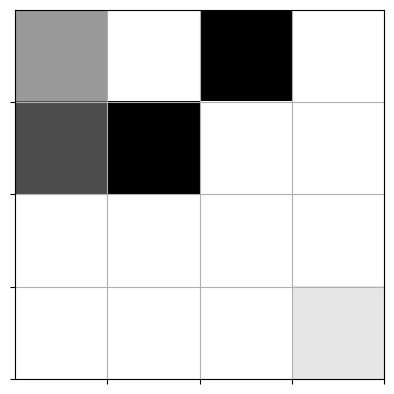

In [36]:
qmaze = Qmaze(maze)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)

[[1.  1.  1.  1. ]
 [1.  1.  0.  1. ]
 [0.5 0.  1.  1. ]
 [1.  1.  1.  1. ]]
[[1.  1.  1.  1. ]
 [1.  1.  1.  1. ]
 [0.5 1.  0.  1. ]
 [1.  0.  1.  1. ]]
[[1.  0.  1.  1. ]
 [1.  1.  1.  1. ]
 [1.  0.5 1.  1. ]
 [1.  1.  0.  1. ]]
[[1.  1.  0.  1. ]
 [1.  0.  1.  1. ]
 [1.  1.  0.5 1. ]
 [1.  1.  1.  1. ]]
[[1.  1.  0.  1. ]
 [1.  1.  0.5 1. ]
 [1.  0.  1.  1. ]
 [1.  1.  1.  1. ]]


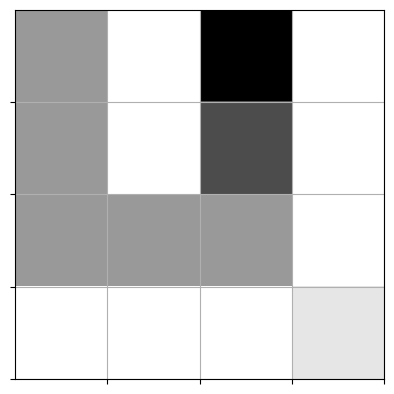

In [37]:
qmaze.act(DOWN)  # move down
qmaze.act(RIGHT)  # move right
qmaze.act(RIGHT)  # move right
qmaze.act(RIGHT)  # move right
qmaze.act(UP)  # move up
show(qmaze)

In [38]:
def play_game(model, qmaze, rat_cell):
    qmaze.reset(rat_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

In [39]:
def completion_check(model, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False
    return True

In [40]:
import numpy as np
import random
from keras.models import Model
from keras.layers import Dense, Input, PReLU
from keras.optimizers import Adam
import datetime
import json

loss_actor_values = []
loss_critic_values = []
win_rate_values = []

class ActorCritic:
    def __init__(self, maze, num_actions, lr_actor=0.001, lr_critic=0.001):
        self.maze = maze
        self.num_actions = num_actions

        self.actor, self.critic = self.build_actor_critic_model(lr_actor, lr_critic)

    def build_actor_critic_model(self, lr_actor, lr_critic):
        input_layer = Input(shape=(self.maze.size,))

        actor_layer = Dense(self.maze.size)(input_layer)
        actor_layer = PReLU()(actor_layer)
        actor_layer = Dense(self.maze.size)(actor_layer)
        actor_layer = PReLU()(actor_layer)
        actor_output = Dense(self.num_actions, activation='softmax')(actor_layer)


        critic_layer = Dense(self.maze.size)(input_layer)
        critic_layer = PReLU()(critic_layer)
        critic_layer = Dense(self.maze.size)(critic_layer)
        critic_layer = PReLU()(critic_layer)
        critic_output = Dense(1, activation='linear')(critic_layer)

        actor_model = Model(inputs=input_layer, outputs=actor_output)
        critic_model = Model(inputs=input_layer, outputs=critic_output)

        actor_model.compile(optimizer=Adam(lr=lr_actor), loss='categorical_crossentropy')
        critic_model.compile(optimizer=Adam(lr=lr_critic), loss='mse')

        return actor_model, critic_model


def format_time(seconds):
    if seconds < 400:
        return "%.1f seconds" % seconds
    elif seconds < 4000:
        return "%.2f minutes" % (seconds / 60.0)
    else:
        return "%.2f hours" % (seconds / 3600.0)

def train_actor_critic(actor_critic, qmaze, n_epoch=100, max_memory=50, data_size=50):
    start_time = datetime.datetime.now()

    win_history = []
    hsize = qmaze.maze.size // 2
    win_rate = 0.0
    imctr = 1

    for epoch in range(n_epoch):
        loss_actor = 0.0
        loss_critic = 0.0
        rat_cell = random.choice(qmaze.free_cells)
        qmaze.reset(rat_cell)
        game_over = False


        envstate = qmaze.observe()

        n_episodes = 0
        while not game_over:
            valid_actions = qmaze.valid_actions()
            if not valid_actions:
                break
            prev_envstate = envstate


            action_probs = actor_critic.actor.predict(np.array([envstate.flatten()]))[0]
            action = np.random.choice(actor_critic.num_actions, p=action_probs)
            envstate, reward, game_status = qmaze.act(action)

            value = actor_critic.critic.predict(np.array([prev_envstate.flatten()]))

            target_value = reward + actor_critic.critic.predict(np.array([envstate.flatten()]))
            advantage = target_value - value

            actor_target = np.zeros(actor_critic.num_actions)
            actor_target[action] = advantage
            actor_target = np.reshape(actor_target, (1, -1))
            loss_actor += actor_critic.actor.train_on_batch(np.array([prev_envstate.flatten()]), actor_target)

            critic_target = np.reshape(target_value, (1, -1))
            loss_critic += actor_critic.critic.train_on_batch(np.array([prev_envstate.flatten()]), critic_target)

            n_episodes += 1

            if game_status == 'win':
                win_history.append(1)
                game_over = True
            elif game_status == 'lose':
                win_history.append(0)
                game_over = True
            else:
                game_over = False

        if len(win_history) > hsize:
            win_rate = sum(win_history[-hsize:]) / hsize

        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        template = "Epoch: {:03d}/{:d} | Loss Actor: {:.4f} | Loss Critic: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
        print(template.format(epoch, n_epoch-1, loss_actor, loss_critic, n_episodes, sum(win_history), win_rate, t))

        loss_actor_values.append(float(loss_actor))
        loss_critic_values.append(float(loss_critic))
        win_rate_values.append(float(win_rate))

        if win_rate > 0.9:
            break

maze = np.array([
    [1., 1., 1., 1.],
    [1., 0., 1., 1.],
    [1., 1., 1., 1.],
    [1., 1., 0., 1.]
])

num_actions = 4
maze_size = maze.size

actor_critic = ActorCritic(maze, num_actions)

qmaze = Qmaze(maze)

train_actor_critic(actor_critic, qmaze, n_epoch=100)


1/1 [==============================] - 0s 107ms/step
[[1.  1.  0.  0.5]
 [1.  1.  1.  1. ]
 [1.  0.  1.  1. ]
 [1.  1.  1.  1. ]]
1/1 [==============================] - 0s 19ms/step
[[1.  1.  1.  0.5]
 [1.  1.  0.  1. ]
 [1.  1.  1.  1. ]
 [1.  0.  1.  1. ]]
1/1 [==============================] - 0s 20ms/step
[[1.  0.  1.  0.5]
 [1.  1.  1.  1. ]
 [1.  1.  0.  1. ]
 [1.  1.  1.  1. ]]
1/1 [==============================] - 0s 19ms/step
[[1.  1.  1.  1. ]
 [1.  0.  1.  0.5]
 [1.  1.  1.  1. ]
 [1.  1.  0.  1. ]]
1/1 [==============================] - 0s 19ms/step
[[1.  1.  0.  1. ]
 [1.  1.  1.  0.5]
 [1.  0.  1.  1. ]
 [1.  1.  1.  1. ]]
1/1 [==============================] - 0s 21ms/step
[[1.  1.  1.  1. ]
 [1.  1.  0.  0.5]
 [1.  1.  1.  1. ]
 [1.  0.  1.  1. ]]
1/1 [==============================] - 0s 23ms/step
[[1.  0.  1.  1. ]
 [1.  1.  1.  1. ]
 [1.  1.  0.  0.5]
 [1.  1.  1.  1. ]]
1/1 [==============================] - 0s 22ms/step
[[1.  1.  1.  1. ]
 [1.  0.  1.  1. ]
 [1.  

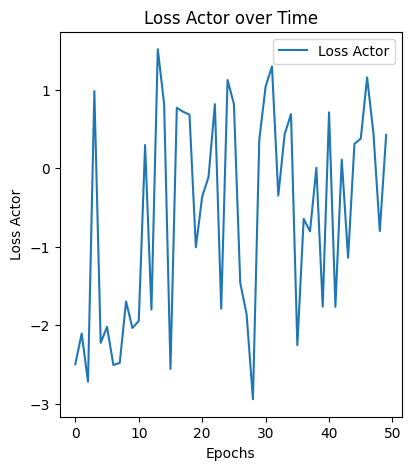

In [41]:
import matplotlib.pyplot as plt
# Plotting the Loss Actor
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(loss_actor_values, label='Loss Actor')
plt.title('Loss Actor over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss Actor')
plt.legend()

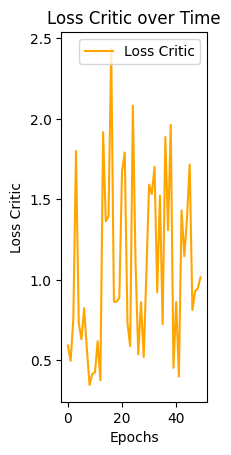

In [42]:
# Plotting the Loss Critic
plt.subplot(1, 3, 2)
plt.plot(loss_critic_values, label='Loss Critic', color='orange')
plt.title('Loss Critic over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss Critic')
plt.legend()

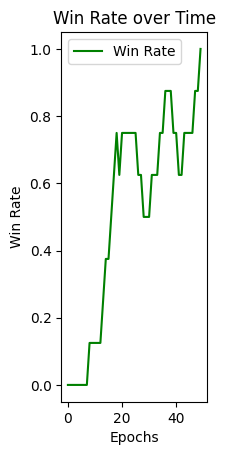

In [43]:
# Plotting the Win Rate
plt.subplot(1, 3, 3)
plt.plot(win_rate_values, label='Win Rate', color='green')
plt.title('Win Rate over Time')
plt.xlabel('Epochs')
plt.ylabel('Win Rate')
plt.legend()